In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
import uproot as ur
import awkward as ak
import time as t
import copy
import scipy.constants as spc
import pandas as pd
print("Awkward version: "+str(ak.__version__))
print("Uproot version: "+str(ur.__version__))

Awkward version: 1.7.0
Uproot version: 4.1.9


In [7]:
track_branches = ['trackEta_EMB1', 'trackPhi_EMB1', 'trackEta_EMB2', 'trackPhi_EMB2', 'trackEta_EMB3', 'trackPhi_EMB3',
                  'trackEta_TileBar0', 'trackPhi_TileBar0', 'trackEta_TileBar1', 'trackPhi_TileBar1',
                  'trackEta_TileBar2', 'trackPhi_TileBar2']

event_branches = ["cluster_nCells", "cluster_cell_ID", "cluster_cell_E", 'cluster_nCells', "nCluster", "eventNumber",
                  "nTrack", "nTruthPart", "truthPartPdgId", "cluster_Eta", "cluster_Phi", 'trackPt', 'trackP',
                  'trackMass', 'trackEta', 'trackPhi', 'truthPartE', 'cluster_ENG_CALIB_TOT', "cluster_E", 'truthPartPt']

geo_branches = ["cell_geo_ID", "cell_geo_eta", "cell_geo_phi", "cell_geo_rPerp", "cell_geo_sampling"]

In [8]:
import sys
path = '/Work/EPE/ML4pi/'
sys.path.append(path)
cPionEvents = path + '/atlas_images/pipm/'
nPionEvents = path + '/atlas_images/pi0/'
my_event = ur.open(cPionEvents+'user.angerami.24559744.OutputStream._000502.root')
my_event.keys()

['EventTree;1', 'CellGeo;1']

In [9]:
event_tree = my_event["EventTree"]
event_tree.show(name_width=42,
                interpretation_width=60)
geo_tree = my_event["CellGeo"]

name                                       | typename                 | interpretation                                              
-------------------------------------------+--------------------------+-------------------------------------------------------------
runNumber                                  | int32_t                  | AsDtype('>i4')
eventNumber                                | int64_t                  | AsDtype('>i8')
lumiBlock                                  | int32_t                  | AsDtype('>i4')
coreFlags                                  | uint32_t                 | AsDtype('>u4')
mcEventNumber                              | int32_t                  | AsDtype('>i4')
mcChannelNumber                            | int32_t                  | AsDtype('>i4')
mcEventWeight                              | float                    | AsDtype('>f4')
nTruthPart                                 | int32_t                  | AsDtype('>i4')
G4PreCalo_n_EM                        

In [10]:
layer_rPerp = np.array([1540., 1733., 1930., 2450., 3010., 3630.])

In [11]:
geo_tree.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
cell_geo_ID          | std::vector<uint64_t>    | AsJagged(AsDtype('>u8'), he...
cell_geo_sampling    | std::vector<uint16_t>    | AsJagged(AsDtype('>u2'), he...
cell_geo_eta         | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
cell_geo_phi         | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
cell_geo_rPerp       | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
cell_geo_deta        | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
cell_geo_dphi        | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
cell_geo_volume      | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
cell_geo_sigma       | std::vector<float>       | AsJagged(AsDtype('>f4'), he...


In [58]:
def DeltaR(coords, ref):
    ''' Straight forward function, expects Nx2 inputs for coords, 1x2 input for ref '''
    ref = np.tile(ref, (len(coords[:,0]), 1))
    DeltaCoords = np.subtract(coords, ref)
    return np.sqrt(DeltaCoords[:,0]**2 + DeltaCoords[:,1]**2) 
    
def dict_from_tree_branches_np(_tree, _branches):
    ''' Helper function to put event data in branches to make things easier to pass to functions,
    pretty self explanatory. This always returns np arrays in the dict. '''
    _dict = dict()
    for _key in _branches:
        _branch = np.ndarray.flatten(_tree.arrays(filter_name=_key)[_key].to_numpy())
        _dict[_key] = _branch
    return _dict

def dict_from_tree_branches(_tree, _branches):
    ''' Helper function to put event data in branches to make things easier to pass to functions,
    pretty self explanatory. '''
    _dict = dict()
    for _key in _branches:
        _branch = _tree.arrays(filter_name=_key)[_key]
        _dict[_key] = _branch
    return _dict

def dict_from_event_tree(_event_tree, _branches):
    ''' The purpose for this separate function is to load np arrays where possible. '''
    _special_keys = ["nCluster", "eventNumber", "nTrack", "nTruthPart"]
    _dict = dict()
    for _key in _branches:
        if _key in _special_keys:
            _branch = _event_tree.arrays(filter_name=_key)[_key].to_numpy()
        else:
            _branch = _event_tree.arrays(filter_name=_key)[_key]
        _dict[_key] = _branch
    return _dict

def find_index_1D(values, dictionary):
    ''' Use a for loop and a dictionary. _values are the IDs to search for. _dict must be in format 
    (cell IDs: index) '''
    idx_vec = np.zeros(len(values), dtype=np.int32)
    for i in range(len(values)):
        idx_vec[i] = dictionary[values[i]]
    return idx_vec

def to_xyz(_coords):
    ''' Simple geometric conversion to xyz from eta, phi, rperp (READ: in this order)
    There is an elegant way to generalize this to be flexible for 1d or 2d, for now 2d
    Inputs: np array of shape (N, 3) where columns are [eta, phi, rPerp]
    Outputs: np array of shape (N, 3) where columns are [x,y,z] '''
    _eta = _coords[:,0]
    _phi = _coords[:,1]
    _rperp = _coords[:,2]
    _theta = 2*np.arctan( np.exp(-_eta) )
    
    cell_x = _rperp*np.cos(_phi)
    cell_y = _rperp*np.sin(_phi)
    cell_z = _rperp/np.tan(_theta)
    
    return np.column_stack([cell_x,cell_y,cell_z])

def track_coords(_idx):
    ''' Returns a list of numpy arrays which contain the track information in the order of EMB1->TileBar2 '''
    
    _num_tracks = nTrack[_idx]
    
    # populate list of numpy arrays with track information in a block 
    _track_list = []
    for i in range(_num_tracks):
        
        _coords = np.empty((6,2))

        _coords[0,0] = ak_trackEta_EMB1[_idx]["trackEta_EMB1"][i]
        _coords[0,1] = ak_trackPhi_EMB1[_idx]["trackPhi_EMB1"][i]
        _coords[1,0] = ak_trackEta_EMB2[_idx]["trackEta_EMB2"][i]
        _coords[1,1] = ak_trackPhi_EMB2[_idx]["trackPhi_EMB2"][i]
        _coords[2,0] = ak_trackEta_EMB3[_idx]["trackEta_EMB3"][i]
        _coords[2,1] = ak_trackPhi_EMB3[_idx]["trackPhi_EMB3"][i]
    
        _coords[3,0] = ak_trackEta_TileBar0[_idx]["trackEta_TileBar0"][i]
        _coords[3,1] = ak_trackPhi_TileBar0[_idx]["trackPhi_TileBar0"][i]
        _coords[4,0] = ak_trackEta_TileBar1[_idx]["trackEta_TileBar1"][i]
        _coords[4,1] = ak_trackPhi_TileBar1[_idx]["trackPhi_TileBar1"][i]
        _coords[5,0] = ak_trackEta_TileBar2[_idx]["trackEta_TileBar2"][i]
        _coords[5,1] = ak_trackPhi_TileBar2[_idx]["trackPhi_TileBar2"][i]
        
        _track_list.append(_coords)
    
    return _track_list

def track_av(_arr):
    ''' Expects a (6,2) np array for the barrel layers in order of eta, phi '''
    _av_Eta = np.sum(_arr[:,0])/6
    _av_Phi = np.sum(_arr[:,1])/6
    return np.array([_av_Eta, _av_Phi])

In [13]:
event_dict = dict_from_event_tree(event_tree, event_branches)
track_dict = dict_from_tree_branches(event_tree, track_branches)
geo_dict = dict_from_tree_branches_np(geo_tree, geo_branches)

In [14]:
# create ordered list of events to use for index slicing
nEvents = len(event_dict['eventNumber'])
all_events = np.arange(0,nEvents,1,dtype=np.int32)
print('All events, shape '+str(all_events.shape))

All events, shape (20000,)


In [15]:
# SINGLE TRACK CUT
single_track_mask = event_dict['nTrack'] == np.full(nEvents, 1)
filtered_event = all_events[single_track_mask]
print('Single Track Indices, shape '+str(np.shape(filtered_event)))
print(filtered_event[0:20])

# CENTRAL TRACK CUT
trackEta_EMB1 = ak.flatten(track_dict['trackEta_EMB1'][filtered_event]).to_numpy()
central_track_mask = np.abs(trackEta_EMB1) < .7
filtered_event = filtered_event[central_track_mask]
# Save this for processing track only files later
central_single_tracks = filtered_event
print('Central track indices, shape '+str(np.shape(filtered_event)))
print(filtered_event[0:20])



Single Track Indices, shape (12055,)
[ 1  2  3  4  5  6  7  8  9 11 13 14 15 16 19 20 22 26 27 28]
Central track indices, shape (3876,)
[  3   6   7  22  28  29  32  33  37  46  50  60  65  95 113 115 137 140
 145 156]


In [16]:
nEvents = len(event_dict['eventNumber'])
all_events = np.arange(0,nEvents,1,dtype=np.int32)
#cluster only mask
cluster_only_mask = single_track_mask = event_dict['nTrack'] == np.full(nEvents, 1)
filtered_event = all_events[single_track_mask]

In [18]:
clusters_tracks = []

for _evt in filtered_event[:10]:
    # pull cluster number, don't need zero as it's loaded as a np array
    _nClust = event_dict["nCluster"][_evt]

    ## DELTA R ##
    if _nClust != 0:
        # pull coordinates of tracks and clusters from event
        # we can get away with the zeroth index because we are working with single track events
        _trackCoords = np.array([event_dict["trackEta"][_evt][0],
                                 event_dict["trackPhi"][_evt][0]])
        _clusterCoords = np.stack((event_dict["cluster_Eta"][_evt].to_numpy(),
                                   event_dict["cluster_Phi"][_evt].to_numpy()), axis=1)

        _DeltaR = DeltaR(_clusterCoords, _trackCoords)
        _DeltaR_mask = _DeltaR < .2
        
        if np.any(_DeltaR_mask):
            clusters_tracks.append(_evt)

print('Central tracks with matched clusters, shape '+str(np.shape(clusters_tracks)))
print(clusters_tracks[0:20])

Central tracks with matched clusters, shape (8,)
[1, 2, 3, 5, 6, 7, 9, 11]


In [20]:
idx_dict = dict( zip( geo_dict['cell_geo_ID'], np.arange(len(geo_dict['cell_geo_ID'])) ) )

In [22]:
event = 3
ak_cluster_cell_ID = event_dict['cluster_cell_ID'][event]
cell_geo_ID = geo_dict['cell_geo_ID']
nClust = len(ak_cluster_cell_ID)

clusters = []
for j in range(nClust):
    
    # find cluster size
    _nInClust = len(ak_cluster_cell_ID[j])

    # make empty array of cluster info
    _cluster = np.zeros((_nInClust, 5))
    
    # index matching
    _indices = find_index_1D(ak_cluster_cell_ID[j].to_numpy(), idx_dict)

    _cluster[:,0] = event_dict["cluster_cell_E"][event][j].to_numpy()
    _cluster[:,1] = geo_dict["cell_geo_eta"][_indices]
    _cluster[:,2] = geo_dict["cell_geo_phi"][_indices]
    _cluster[:,3] = geo_dict["cell_geo_rPerp"][_indices]
    _cluster[:,4] = geo_dict["cell_geo_sampling"][_indices]
    
    clusters.append(_cluster)

print('Number of Clusters: '+str(len(clusters)))
print('Number in each:')
for n in range(len(clusters)):
    print(len(clusters[n]))

Number of Clusters: 2
Number in each:
73
9


In [23]:
barrel_layer_rPerp = np.array([1540., 1733., 1930., 2450., 3010., 3630.])

n_tracks = event_dict['nTrack'][event]
print('Number of tracks: '+str(n_tracks))

tracks = []
for t in range(n_tracks):    
    track = np.zeros(12)
    i = 0
    for _key in track_branches:
        track[i] = track_dict[_key][event][t]
        i += 1
    track = np.reshape(track, (6,2))
    trackP = np.full(6, event_dict['trackP'][event][t])
    track = np.column_stack((trackP, track, barrel_layer_rPerp, np.array([1,2,3,12,13,14])))
    tracks.append(track)

Number of tracks: 1


In [25]:
cluster_xyz = []
for i in range(len(clusters)):
    _xyz = to_xyz(clusters[i][:,1:4])
    cluster_xyz.append(_xyz)

tracks_xyz = []
for i in range(len(tracks)):
    _xyz = to_xyz(tracks[i][:,1:4])
    tracks_xyz.append(_xyz)

In [26]:
# keep making this bigger as the events go on
colors = ['blue', 'red', 'gold', 'darkturquoise', 'indigo', 'crimson', 'orange']

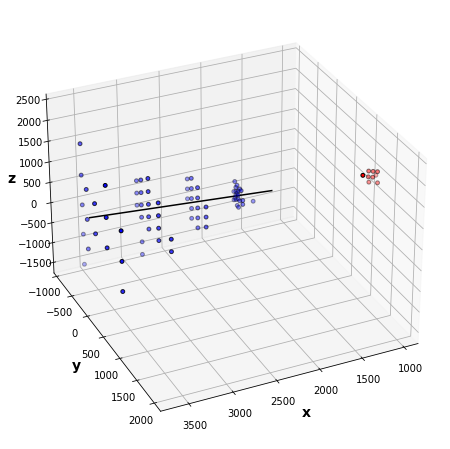

In [27]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
ax.view_init(elev=30, azim=65)
for i in range(len(cluster_xyz)):
    ax.scatter(cluster_xyz[i][:,0], cluster_xyz[i][:,1], cluster_xyz[i][:,2], color=colors[i],
              s=15, edgecolor='black')
for i in range(len(tracks_xyz)):
    ax.plot(tracks_xyz[i][:,0], tracks_xyz[i][:,1], tracks_xyz[i][:,2], color='black')
# ax.set_xlim(-500,-3000)
# ax.set_ylim(-3000,-500)
# ax.set_zlim(500,3500)
ax.set_xlabel('x', fontsize=14, fontweight='bold')
ax.set_ylabel('y', fontsize=14, fontweight='bold')
ax.set_zlabel('z', fontsize=14, fontweight='bold')
# plt.tight_layout()
# plt.savefig('Plots/clusters_3d_scatter_elev30_azim65_wTrack_evt22_2021-06-01.png', format='png')
plt.show()

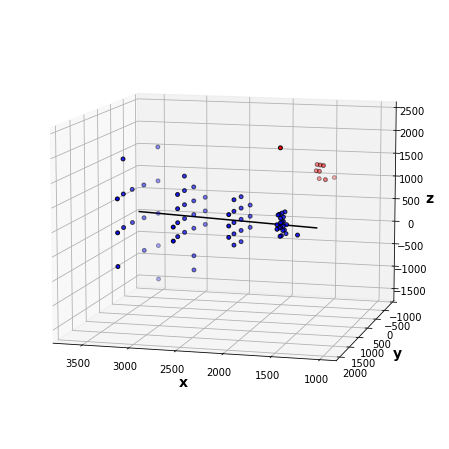

In [28]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
ax.view_init(elev=10, azim=105)
for i in range(len(cluster_xyz)):
    ax.scatter(cluster_xyz[i][:,0], cluster_xyz[i][:,1], cluster_xyz[i][:,2], color=colors[i],
              s=15, edgecolor='black')
for i in range(len(tracks_xyz)):
    ax.plot(tracks_xyz[i][:,0], tracks_xyz[i][:,1], tracks_xyz[i][:,2], color='black')
# ax.set_xlim(-1000,-3000)
# ax.set_ylim(-3000,-750)
# ax.set_zlim(500,3500)
ax.set_xlabel('x', fontsize=14, fontweight='bold')
ax.set_ylabel('y', fontsize=14, fontweight='bold')
ax.set_zlabel('z', fontsize=14, fontweight='bold')
# plt.tight_layout()
# plt.savefig('Plots/clusters_3d_scatter_elev10_azim105_wTrack_evt22_2021-06-01.png', format='png')
plt.show()

In [62]:
cell_geo_ID = geo_tree.arrays(filter_name='cell_geo_ID')[0]["cell_geo_ID"].to_numpy()
cell_geo_eta = geo_tree.arrays(filter_name='cell_geo_eta')[0]["cell_geo_eta"].to_numpy()
cell_geo_phi = geo_tree.arrays(filter_name='cell_geo_phi')[0]["cell_geo_phi"].to_numpy()
cell_geo_rPerp = geo_tree.arrays(filter_name='cell_geo_rPerp')[0]["cell_geo_rPerp"].to_numpy()
cell_geo_deta = geo_tree.arrays(filter_name='cell_geo_deta')[0]["cell_geo_deta"].to_numpy()
cell_geo_dphi = geo_tree.arrays(filter_name='cell_geo_dphi')[0]["cell_geo_dphi"].to_numpy()
cell_geo_sampling = geo_tree.arrays(filter_name='cell_geo_sampling')[0]["cell_geo_sampling"].to_numpy()

''' Notes: -because the geometry information is stored differently in cell_geo we can simply extract the np
arrays by referencing the zeroth element of the awkward arrays. This is because the cell geos are a single
nested ak array (it seems so far anyways) '''

# Event information
ak_cluster_nCells = event_tree.arrays(filter_name="cluster_nCells")
ak_cluster_cell_ID = event_tree.arrays(filter_name="cluster_cell_ID")
ak_cluster_cell_E = event_tree.arrays(filter_name="cluster_cell_E")
nCluster = event_tree.arrays(library='np')["nCluster"]
eventNumber = event_tree.arrays(library='np')["eventNumber"]
nTrack = event_tree.arrays(library='np')["nTrack"]
ak_cluster_Eta = event_tree.arrays(filter_name="cluster_Eta")
ak_cluster_Phi = event_tree.arrays(filter_name="cluster_Phi")
ak_cluster_CENTER_MAG = event_tree.arrays(filter_name="cluster_Eta")

In [64]:
ak_trackEta_EMB1 = event_tree.arrays(filter_name="trackEta_EMB1")
ak_trackEta_EMB2 = event_tree.arrays(filter_name="trackEta_EMB2")
ak_trackEta_EMB3 = event_tree.arrays(filter_name="trackEta_EMB3")
ak_trackPhi_EMB1 = event_tree.arrays(filter_name="trackPhi_EMB1")
ak_trackPhi_EMB2 = event_tree.arrays(filter_name="trackPhi_EMB2")
ak_trackPhi_EMB3 = event_tree.arrays(filter_name="trackPhi_EMB3")

ak_trackEta_TileBar0 = event_tree.arrays(filter_name="trackEta_TileBar0")
ak_trackEta_TileBar1 = event_tree.arrays(filter_name="trackEta_TileBar1")
ak_trackEta_TileBar2 = event_tree.arrays(filter_name="trackEta_TileBar2")
ak_trackPhi_TileBar0 = event_tree.arrays(filter_name="trackPhi_TileBar0")
ak_trackPhi_TileBar1 = event_tree.arrays(filter_name="trackPhi_TileBar1")
ak_trackPhi_TileBar2 = event_tree.arrays(filter_name="trackPhi_TileBar2")

ak_trackPt = event_tree.arrays(filter_name='trackPt')['trackPt']
nTrack = event_tree.arrays(filter_name='nTrack')['nTrack'].to_numpy()
ak_trackNumberOfPixelHits = event_tree.arrays(filter_name='trackNumberOfPixelHits')['trackNumberOfPixelHits']
ak_trackNumberOfSCTHits = event_tree["trackNumberOfSCTHits"].arrays(library="np")['trackNumberOfSCTHits']
ak_trackChiSquared = event_tree.arrays(filter_name='trackChiSquared')['trackChiSquared']
ak_trackNumberDOF = event_tree.arrays(filter_name='trackNumberDOF')['trackNumberDOF']
ak_trackD0 = event_tree.arrays(filter_name='trackD0')['trackD0']
ak_trackZ0 = event_tree.arrays(filter_name='trackZ0')['trackZ0']

In [31]:
N_events = len(ak_cluster_nCells)
event_search = range(N_events)

# Create list for sampling layers per event!
sample_layers = []
# list of event indices with one or more clusters in EMB1-3 or TileBar0-2
barrel_events = []
calo_layer_filter = np.array([1,2,3,12,13,14])

for _evt_idx in event_search:
    cluster_cell_ID = ak_cluster_cell_ID["cluster_cell_ID"][_evt_idx]
    
    # create unique list of sampling layers for every cluster
    _event_layers = []

    # print('Working on event '+str(_evt_idx))
    for j in range(len(cluster_cell_ID)):
        ''' loop through each cluster of the event '''

        for l in range(len(cluster_cell_ID[j])):
            ''' loop through the cluster elements searching for new layer numbers'''
            # grab the first cell_geo_ID
            _cell_geo_tag = cluster_cell_ID[j][l]
        
            # find the index of the cell_geo_ID, use [0][0] becuase of np.where return
            _cell_geo_idx = np.where(cell_geo_ID == _cell_geo_tag)[0][0]

            # find the sampling layer based on the index
            this_layer = cell_geo_sampling[_cell_geo_idx]

            if not np.isin(this_layer, _event_layers):
                _event_layers.append(this_layer)      
            
        # Append the layer to the list, definitely want sample layers to be from each event
        sample_layers.extend(_event_layers)
        
    # add event to list if one is in the barrel layer
    if np.any(np.isin(_event_layers, calo_layer_filter)):
        barrel_events.append(_evt_idx)
        
sample_layers = np.array(sample_layers)
barrel_events = np.array(barrel_events)

In [53]:
for a in ak_cluster_cell_ID["cluster_cell_ID"][1]:
    print(a)

[751051906, 751051904, 751051908, 751051394, ... 813752320, 823468032, 823721984]
[1208225536, 1208241920, 1208225280, 1208241664, 813760512]
[778047098, 778047100, 778047102, 778046588, ... 778047608, 776217210, 776217722]


In [54]:
## Giant event selection loop ##

# Instantiate an index list with multiple tracks to look at later
multiple_tracks_barrel = []

# For now, just look at single track events
single_track_barrel = []

# Instantiate overall keep event list
filtered_events = []

for event in barrel_events:
    keep_event = True
    
    # Track info
    _num_tracks = nTrack[event]
    if _num_tracks == 1:
        single_track_barrel.append(event)
        
    elif _num_tracks >= 2:
        multiple_tracks_barrel.append(event)
    
    multiple_track_bool = np.full((_num_tracks,), True, dtype=np.bool_)
    for i in range(_num_tracks):
        
        ## trackChiSquared ##
        _trackChiSq = ak_trackChiSquared[event][i]
        _trackNumberDOF = ak_trackNumberDOF[event][i]
        # un-sure yet how to make this ChiSquared cut
        
        ## Silicon Hits ##
        _siliconHits = ak_trackNumberOfPixelHits[event][i]
        _siliconHits += ak_trackNumberOfSCTHits[event][i]
        if _siliconHits < 3:
            multiple_track_bool[i] = False
        
        ## trackPt ##
        _trackPt = ak_trackPt[event][i]
        if _trackPt < 500:
            multiple_track_bool[i] = False
            
        ## Track separation doohickey, add helper functions for this
        # need to do this for every track I guess
        # 1) Find nearest cluster center
        # 2) find Delta_r for this
        # 3) append Delta_r to list
        ''' note finding track separation will be tricky for small r tracks ...'''
        
    
    # If all tracks fail one or more condition tests above then we do not keep the event
    if np.all(multiple_track_bool == False):
        keep_event = False
        
    if keep_event:
        filtered_events.append(event)

## Check events
print(single_track_barrel[0:10])
print(multiple_tracks_barrel[0:10])
print(filtered_events[0:10])

[2, 3, 6, 7, 11, 14, 20, 22, 26, 28]
[119, 139, 166, 287, 308, 451, 824, 852, 1113, 1334]
[6, 22, 26, 29, 33, 42, 68, 80, 87, 95]


In [61]:
len(single_track_barrel)

7196

In [65]:
Delta_r_list = []

for _evt in single_track_barrel:
    # we know that we are only looking at one track so zero index is safe
    _single_track_pos = track_coords(_evt)[0]
    _avg_track_pos = track_av(_single_track_pos)
    
    _num_cluster = nCluster[_evt]
    # check through all the cluster centers and find the shortest distance
    _dist = np.full((_num_cluster,), 10, dtype = np.float32)
    
    for i in range(_num_cluster):
        _clust_Eta = ak_cluster_Eta["cluster_Eta"][_evt][i]
        _clust_Phi = ak_cluster_Phi["cluster_Phi"][_evt][i]
        _clust_coord = np.array([_clust_Eta, _clust_Phi])
        _dist[i] = DeltaR(_avg_track_pos, _clust_coord)
    
    Delta_r_list.append(np.min(_dist))

Delta_r_list = np.array(Delta_r_list)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed